In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    print(f'Batch size: {images.size(0)}') 
    break 


Batch size: 64


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [45]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

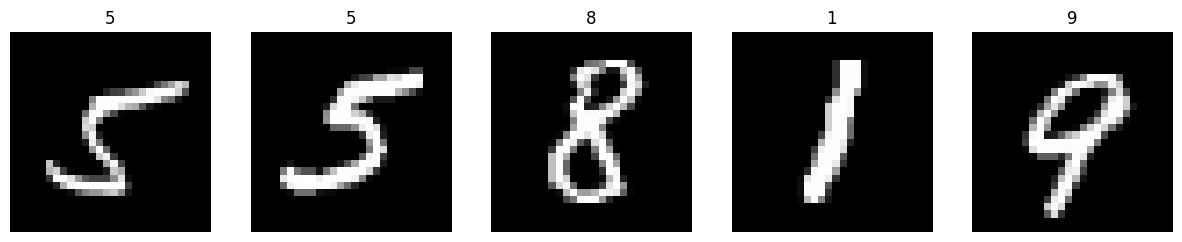

In [47]:

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

# Configuration pour les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    image = x[i].numpy().squeeze()  
    label = y[i].item()

    axes[i].imshow(image, cmap='gray') 
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.show()


In [58]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        
        # Définition de l'architecture du réseau
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),

            nn.Linear(in_features=50, out_features=output_size),
        )

    def forward(self, x):
        return self.net(x)

n_kernels = 6
input_size = 28 * 28
output_size = 10 

model = ConvNet(input_size=input_size, n_kernels=n_kernels, output_size=output_size)

print(model)


ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=96, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [59]:
# Fonction Train

def train(model, train_loader, device, n_epoch=1, perm=torch.arange(0, 784).long()):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())
    
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)


            data = data.view(-1, 28*28) 
            data = data[:, perm] 
            data = data.view(-1, 1, 28, 28) 

            optimizer.zero_grad() 
            logits = model(data) 
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 100 == 99: 
                print(f'Epoch={epoch}, Step={i+1}: Loss={running_loss / 100:.4f}')
                running_loss = 0.0

model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
model.to(device) # TO GPU

train(model, train_loader, device, n_epoch=1)

 11%|█▏        | 107/938 [00:01<00:13, 62.98it/s]

Epoch=0, Step=100: Loss=1.3073


 23%|██▎       | 213/938 [00:03<00:10, 70.51it/s]

Epoch=0, Step=200: Loss=0.3395


 33%|███▎      | 309/938 [00:04<00:08, 70.74it/s]

Epoch=0, Step=300: Loss=0.2505


 44%|████▍     | 414/938 [00:06<00:07, 74.43it/s]

Epoch=0, Step=400: Loss=0.1983


 54%|█████▍    | 511/938 [00:07<00:06, 69.11it/s]

Epoch=0, Step=500: Loss=0.1574


 65%|██████▌   | 610/938 [00:08<00:04, 70.79it/s]

Epoch=0, Step=600: Loss=0.1472


 75%|███████▌  | 708/938 [00:10<00:03, 64.04it/s]

Epoch=0, Step=700: Loss=0.1576


 86%|████████▋ | 811/938 [00:11<00:01, 70.84it/s]

Epoch=0, Step=800: Loss=0.1261


 97%|█████████▋| 908/938 [00:13<00:00, 72.57it/s]

Epoch=0, Step=900: Loss=0.1067


100%|██████████| 938/938 [00:13<00:00, 69.04it/s]


In [73]:
def test(model, test_loader, device, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 

            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            logits = model(data)  # Prédiction par le modèle
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()
            pred = logits.argmax(dim=1, keepdim=True)

            #correct += pred.eq(target.view_as(pred)).sum().item() 
            correct += (pred == target).sum()

    test_loss /= len(test_loader.dataset)  # Calculer la perte moyenne
    accuracy = correct / len(test_loader.dataset)  # Calculer l'accuracy

    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
    return test_loss, accuracy

model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
model.to(device)


test_loss, test_accuracy = test(model, test_loader, device)


Test loss: 2.3162, Accuracy: 6.2096
